In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from googleapiclient.discovery import build
from prophet import Prophet

from matplotlib.ticker import FuncFormatter

In [4]:
api_key = '...'
#channel_id = 'UCUaT_39o1x6qWjz7K2pWcgw'
channel_ids = ['UCX6OQ3DkcsbYNE6H8uQQuVA', #MrBeast
               'UCAiLfjNXkNv24uhpzUgPa6A', #BeastPhilanthropy
               'UCIPPMRA040LQr5QPyJEbmXA', #MrBeastGaming
               'UC4-79UOlP48-QNGgCko5p2g', #MrBeast 2
               'UCUaT_39o1x6qWjz7K2pWcgw', #Beast Reacts
              ]

youtube = build('youtube', 'v3', developerKey = api_key)

In [5]:
plt.style.use('seaborn-v0_8-darkgrid')

## Get channel info

In [6]:
def get_channel_stats(youtube, channel_ids):
    all_channels_data = []
    request = youtube.channels().list(
                    part='snippet, contentDetails,statistics',
                    id = ','.join(channel_ids)) # split values from list as string with ','
    response = request.execute()

    for i in range(len(response['items'])):
        data = dict(Channel_name = response['items'][i]['snippet']['title'],
                    Subscribers = response['items'][i]['statistics']['subscriberCount'],
                    Views = response['items'][i]['statistics']['viewCount'],
                    Total_videos = response['items'][i]['statistics']['videoCount'],
                    uploads_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_channels_data.append(data)
    
    return all_channels_data

In [7]:
channel_statistics = get_channel_stats(youtube, channel_ids)
channel_statistics

[{'Channel_name': 'Beast Philanthropy',
  'Subscribers': '21000000',
  'Views': '584109859',
  'Total_videos': '38',
  'uploads_id': 'UUAiLfjNXkNv24uhpzUgPa6A'},
 {'Channel_name': 'MrBeast',
  'Subscribers': '232000000',
  'Views': '41485846757',
  'Total_videos': '774',
  'uploads_id': 'UUX6OQ3DkcsbYNE6H8uQQuVA'},
 {'Channel_name': 'MrBeast 2',
  'Subscribers': '36100000',
  'Views': '6133433315',
  'Total_videos': '116',
  'uploads_id': 'UU4-79UOlP48-QNGgCko5p2g'},
 {'Channel_name': 'Beast Reacts',
  'Subscribers': '31900000',
  'Views': '5609112496',
  'Total_videos': '239',
  'uploads_id': 'UUUaT_39o1x6qWjz7K2pWcgw'},
 {'Channel_name': 'MrBeast Gaming',
  'Subscribers': '41300000',
  'Views': '7326228508',
  'Total_videos': '141',
  'uploads_id': 'UUIPPMRA040LQr5QPyJEbmXA'}]

In [8]:
channels_data = pd.DataFrame(channel_statistics)
channels_data

,Channel_name,Subscribers,Views,Total_videos,uploads_id
0,Beast Philanthropy,21000000,584109859,38,UUAiLfjNXkNv24uhpzUgPa6A
1,MrBeast,232000000,41485846757,774,UUX6OQ3DkcsbYNE6H8uQQuVA
2,MrBeast 2,36100000,6133433315,116,UU4-79UOlP48-QNGgCko5p2g
3,Beast Reacts,31900000,5609112496,239,UUUaT_39o1x6qWjz7K2pWcgw
4,MrBeast Gaming,41300000,7326228508,141,UUIPPMRA040LQr5QPyJEbmXA


In [9]:
channels_data['Subscribers'] = pd.to_numeric(channels_data['Subscribers'])
channels_data['Views'] = pd.to_numeric(channels_data['Views'])
channels_data['Total_videos'] = pd.to_numeric(channels_data['Total_videos'])

In [10]:
channels_data.dtypes

Channel_name    object
Subscribers      int64
Views            int64
Total_videos     int64
uploads_id      object
dtype: object

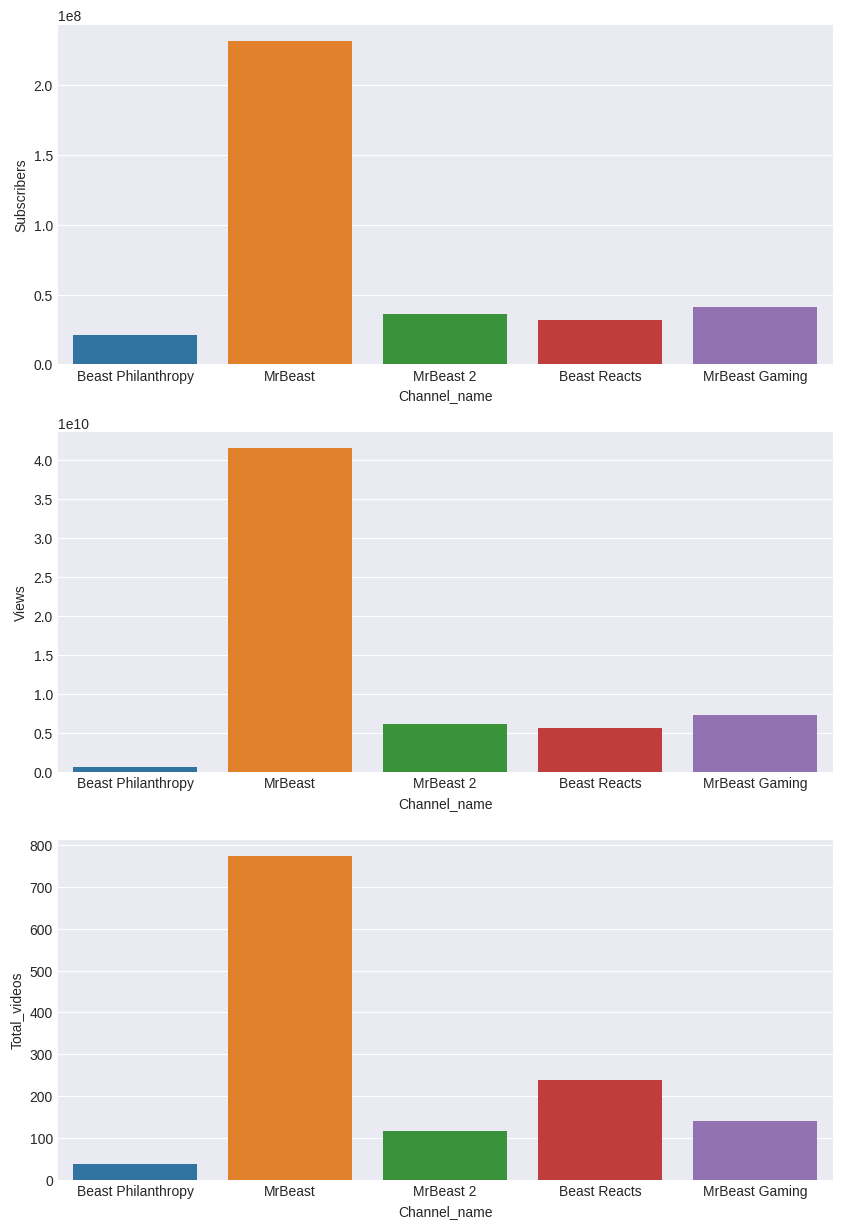

In [11]:
fig, axs = plt.subplots(nrows=3, figsize = (10, 15))

sns.barplot(x='Channel_name', y='Subscribers', data=channels_data, ax=axs[0])
sns.barplot(x='Channel_name', y='Views', data=channels_data, ax=axs[1])
sns.barplot(x='Channel_name',y='Total_videos', data=channels_data, ax=axs[2]);

## Get video ids

In [12]:
channels_data

,Channel_name,Subscribers,Views,Total_videos,uploads_id
0,Beast Philanthropy,21000000,584109859,38,UUAiLfjNXkNv24uhpzUgPa6A
1,MrBeast,232000000,41485846757,774,UUX6OQ3DkcsbYNE6H8uQQuVA
2,MrBeast 2,36100000,6133433315,116,UU4-79UOlP48-QNGgCko5p2g
3,Beast Reacts,31900000,5609112496,239,UUUaT_39o1x6qWjz7K2pWcgw
4,MrBeast Gaming,41300000,7326228508,141,UUIPPMRA040LQr5QPyJEbmXA


In [57]:
uploads_id = channels_data.loc[channels_data['Channel_name']=='Beast Reacts', 'uploads_id'].iloc[0]

In [58]:
uploads_id

'UUUaT_39o1x6qWjz7K2pWcgw'

In [59]:
def get_video_ids(youtube, uploads_id):
    
    request = youtube.playlistItems().list(
                       part = 'contentDetails',
                       playlistId = uploads_id,
                       maxResults = 50)
    response = request.execute()

    video_ids = []

    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    more_pages = True

    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
                request = youtube.playlistItems().list(
                                   part = 'contentDetails',
                                   playlistId = uploads_id,
                                   maxResults = 50,
                                   pageToken = next_page_token)
                response = request.execute()

                for i in range(len(response['items'])):
                    video_ids.append(response['items'][i]['contentDetails']['videoId'])

                next_page_token = response.get('nextPageToken')

    
    
    return video_ids

In [60]:
video_ids = get_video_ids(youtube, uploads_id)

In [61]:
video_ids

['70dS-T5p07U',
 'uBOvI20os3o',
 'Ops-wTBCTwA',
 'C8HhPQ8qc1k',
 'bReHusqxnvw',
 'qAtyzHZc7l8',
 '1atCTSRJHH0',
 'IYjSmlWG-4A',
 'F5wMOCZHcH4',
 'ZGNj5lOtNnI',
 'NigrQ9UcJy4',
 '0Onuvef2Ul8',
 'I4bxOuhl8TE',
 'RcTLBsXvzQk',
 '5gAAAOkqaxg',
 'HR1ig6u9-6A',
 'AOkNx8KAtR4',
 'DvkTX-AquQo',
 '0RoQ3V26jYw',
 '9ridm0GeHRg',
 'TbLm5CCAbIU',
 'qFYcwbu-H-s',
 'OT-xDbFQ4aY',
 '8kWrN2bgvSA',
 'T2nzYFz028U',
 'fqq9TSkSe2U',
 'Xzkzp2Y1t0o',
 'pgvBPAsDf2A',
 '_t9LL1VcG3Q',
 'T1QUEKLNPtA',
 'ZgxNvOhwNbU',
 '5orcB4yyjoU',
 '5s6iBACk-E4',
 'jgyTwWtvMdE',
 'IWWv3dq4Gb4',
 'd2-BHPI8ggM',
 'GjMmsEwIcl0',
 'wUoxbm9MUc0',
 '_iz5_DuY_II',
 'CK78QUMcZL8',
 'B5WUhJUog_M',
 'esDlUtMQmeU',
 'L4KWhKY85cY',
 '6-aGt23ytyI',
 'plTvQ1g59yM',
 'GdL3bmxUNYs',
 'Dt-IFSvDJic',
 'diwlAeVHNCI',
 'iCddOcxInWs',
 'qK_qK_UKu-Q',
 'zySUlGXbXvA',
 '8uNEJBYGyFA',
 'T906mp5kYfM',
 'mEKGarAbyxk',
 'Iu8ZmhRphSU',
 'pHz9tefho28',
 '7I0Qo9qlVlk',
 'O5xlSWOQsDA',
 'Q-Kc5EfIRlk',
 'e-Og20cYMv0',
 '57tOReFC968',
 'ySXPnjStay4',
 'v9WSjE

## Get video deatails

In [62]:
def get_video_details(youtube, video_ids):
    all_video_stats = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
                    part = 'snippet,statistics',
                    id = ','.join(video_ids[i:i+50]))
        response = request.execute()

        for video in response['items']:
            #video_stats = video['statistics']['likecount']
            video_stats = dict(Title = video['snippet']['title'],
                               Published_date = video['snippet']['publishedAt'],
                               Views = video['statistics']['viewCount'],
                               Likes = video['statistics'].get('likeCount'),
                               Comments = video['statistics'].get('commentCount'),
                              )
            
            all_video_stats.append(video_stats)
           
        

    return all_video_stats

In [63]:
get_video_details(youtube, video_ids)

[{'Title': 'Funniest Animals On The Internet!',
  'Published_date': '2023-04-25T20:00:03Z',
  'Views': '27560101',
  'Likes': '509929',
  'Comments': '14474'},
 {'Title': 'Level 1 To Level 100 Trickshots!',
  'Published_date': '2023-03-30T20:00:50Z',
  'Views': '18667365',
  'Likes': '336386',
  'Comments': '10771'},
 {'Title': 'Most Expensive Fails!',
  'Published_date': '2023-03-17T20:00:45Z',
  'Views': '35132701',
  'Likes': '605017',
  'Comments': '8685'},
 {'Title': 'Fastest Onion Ever Eaten!',
  'Published_date': '2023-03-14T20:00:01Z',
  'Views': '23985492',
  'Likes': '344052',
  'Comments': '4249'},
 {'Title': 'Impossible 0.0000001% Odds!',
  'Published_date': '2023-03-09T21:00:00Z',
  'Views': '55543522',
  'Likes': '690193',
  'Comments': '8129'},
 {'Title': 'Unluckiest People In The World!',
  'Published_date': '2023-02-24T21:00:10Z',
  'Views': '44216466',
  'Likes': '584307',
  'Comments': '9993'},
 {'Title': 'Rarest Things On Earth!',
  'Published_date': '2023-02-17T21:

In [64]:
video_details = get_video_details(youtube, video_ids)

In [65]:
video_data = pd.DataFrame(video_details)

In [66]:
video_data

,Title,Published_date,Views,Likes,Comments
0,Funniest Animals On The Internet!,2023-04-25T20:00:03Z,27560101,509929,14474
1,Level 1 To Level 100 Trickshots!,2023-03-30T20:00:50Z,18667365,336386,10771
2,Most Expensive Fails!,2023-03-17T20:00:45Z,35132701,605017,8685
3,Fastest Onion Ever Eaten!,2023-03-14T20:00:01Z,23985492,344052,4249
4,Impossible 0.0000001% Odds!,2023-03-09T21:00:00Z,55543522,690193,8129
...,...,...,...,...,...
235,Super unexpected DIY life hacks,2018-11-12T21:18:49Z,1473969,25945,2892
236,Super Satisfying Kinetic Sand DIY,2018-11-07T22:36:54Z,3683772,48333,4062
237,Amazing Match bottle DIY Experiments,2018-10-31T21:04:27Z,3685735,47691,2984
238,The Best Last Minute Halloween DIY Life Hacks,2018-10-26T16:57:21Z,8524341,67820,7949


In [67]:
video_data['Published_date'] = pd.to_datetime(video_data['Published_date']).dt.date
video_data['Views'] = pd.to_numeric(video_data['Views'])
video_data['Likes'] = pd.to_numeric(video_data['Likes'])
video_data['Comments'] = pd.to_numeric(video_data['Comments'])
video_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Title           240 non-null    object
 1   Published_date  240 non-null    object
 2   Views           240 non-null    int64 
 3   Likes           240 non-null    int64 
 4   Comments        240 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 9.5+ KB


In [68]:
video_data

,Title,Published_date,Views,Likes,Comments
0,Funniest Animals On The Internet!,2023-04-25,27560101,509929,14474
1,Level 1 To Level 100 Trickshots!,2023-03-30,18667365,336386,10771
2,Most Expensive Fails!,2023-03-17,35132701,605017,8685
3,Fastest Onion Ever Eaten!,2023-03-14,23985492,344052,4249
4,Impossible 0.0000001% Odds!,2023-03-09,55543522,690193,8129
...,...,...,...,...,...
235,Super unexpected DIY life hacks,2018-11-12,1473969,25945,2892
236,Super Satisfying Kinetic Sand DIY,2018-11-07,3683772,48333,4062
237,Amazing Match bottle DIY Experiments,2018-10-31,3685735,47691,2984
238,The Best Last Minute Halloween DIY Life Hacks,2018-10-26,8524341,67820,7949


In [69]:
top10_vid = video_data.sort_values(by='Views', ascending=False).head(10)
last10_vid = video_data.sort_values(by='Views', ascending=False).tail(10)

In [70]:
top10_vid

,Title,Published_date,Views,Likes,Comments
46,How Long Does A Pencil Last?,2022-02-07,106588159,1507100,30946
54,World's Fastest Workers!,2021-12-22,98282429,4149762,25912
24,World’s Richest Youtuber!,2022-08-19,92086018,3677137,7264
50,World's Luckiest People!,2022-01-06,92018225,1177575,17074
39,Moments Before Disaster!,2022-04-01,87247936,1048719,13872
49,Most Expensive iPhone!,2022-01-10,81707526,1161615,13202
62,World's Most Viewed TikToks!,2021-11-22,80721611,2059099,30568
66,Extreme Try Not To Laugh Challenge!,2021-10-25,80609670,1051856,17713
61,World’s Sharpest Knife!,2021-11-29,79149303,1197023,16489
84,Insane BMX Downhill!,2021-06-13,77153163,1049621,17043


In [71]:
last10_vid

,Title,Published_date,Views,Likes,Comments
120,Ultimate Chainsaw vs Pepsi!,2019-12-19,976621,16838,774
116,"1,000 Degree Ball VS Frozen Water",2020-01-09,937296,15513,859
114,Magma Vs Liquid Nitrogen!,2020-01-23,878146,13716,505
185,I Put a Tooth In Coca Cola For 24 Hours,2019-05-18,870945,16499,978
197,GAS TORCH vs GUMMY BEAR,2019-03-10,798568,10287,1051
195,SUPER POWERFUL FIREWORK VS LOCK,2019-03-14,755605,10332,798
192,3 Amazing DIY Magic Illusions!,2019-03-22,745281,12060,620
198,FIREWORK VS WATERMELON EXPERIMENT,2019-03-08,684450,12754,910
194,MICROWAVING ALUMINIUM FOIL,2019-03-16,587602,11789,1127
169,Mr.Beast Live Stream,2019-07-11,0,63,0


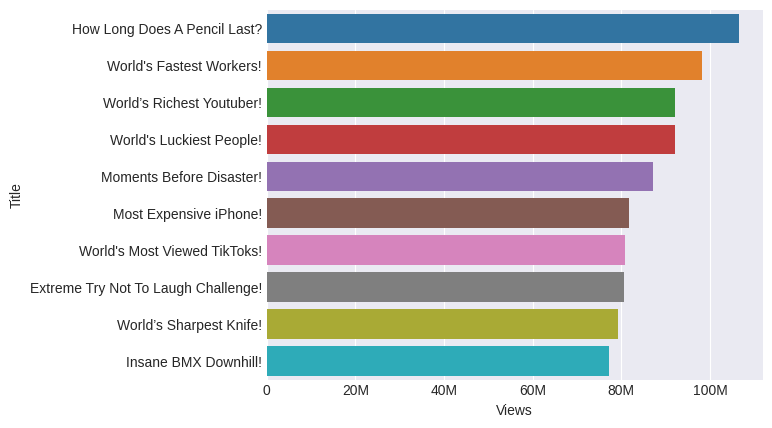

In [72]:
def format_ticks(value, _):
    if value >= 1e9:
        return f'{value / 1e9:.0f}B'
    elif value >= 1e6:
        return f'{value / 1e6:.0f}M'
    elif value >= 1e3:
        return f'{value / 1e3:.0f}K'
    else:
        return f'{value:.0f}'

plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))

sns.barplot(x='Views', y = 'Title', data = top10_vid);

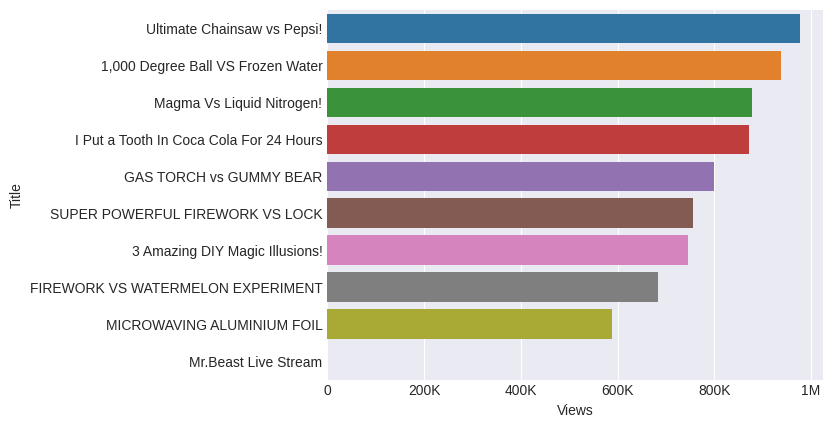

In [73]:
def format_ticks(value, _):
    if value >= 1e9:
        return f'{value / 1e9:.0f}B'
    elif value >= 1e6:
        return f'{value / 1e6:.0f}M'
    elif value >= 1e3:
        return f'{value / 1e3:.0f}K'
    else:
        return f'{value:.0f}'

plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))


sns.barplot(x='Views', y = 'Title', data = last10_vid);

In [74]:
video_data['Month'] = pd.to_datetime(video_data['Published_date']).dt.strftime('%b')
video_data['Year'] = pd.to_datetime(video_data['Published_date']).dt.year

In [75]:
video_data

,Title,Published_date,Views,Likes,Comments,Month,Year
0,Funniest Animals On The Internet!,2023-04-25,27560101,509929,14474,Apr,2023
1,Level 1 To Level 100 Trickshots!,2023-03-30,18667365,336386,10771,Mar,2023
2,Most Expensive Fails!,2023-03-17,35132701,605017,8685,Mar,2023
3,Fastest Onion Ever Eaten!,2023-03-14,23985492,344052,4249,Mar,2023
4,Impossible 0.0000001% Odds!,2023-03-09,55543522,690193,8129,Mar,2023
...,...,...,...,...,...,...,...
235,Super unexpected DIY life hacks,2018-11-12,1473969,25945,2892,Nov,2018
236,Super Satisfying Kinetic Sand DIY,2018-11-07,3683772,48333,4062,Nov,2018
237,Amazing Match bottle DIY Experiments,2018-10-31,3685735,47691,2984,Oct,2018
238,The Best Last Minute Halloween DIY Life Hacks,2018-10-26,8524341,67820,7949,Oct,2018


## Assuming creators make 0,012$ per view

In [76]:
video_data['Money_per_view'] = video_data['Views'] * 0.012
video_data

,Title,Published_date,Views,Likes,Comments,Month,Year,Money_per_view
0,Funniest Animals On The Internet!,2023-04-25,27560101,509929,14474,Apr,2023,330721.212
1,Level 1 To Level 100 Trickshots!,2023-03-30,18667365,336386,10771,Mar,2023,224008.380
2,Most Expensive Fails!,2023-03-17,35132701,605017,8685,Mar,2023,421592.412
3,Fastest Onion Ever Eaten!,2023-03-14,23985492,344052,4249,Mar,2023,287825.904
4,Impossible 0.0000001% Odds!,2023-03-09,55543522,690193,8129,Mar,2023,666522.264
...,...,...,...,...,...,...,...,...
235,Super unexpected DIY life hacks,2018-11-12,1473969,25945,2892,Nov,2018,17687.628
236,Super Satisfying Kinetic Sand DIY,2018-11-07,3683772,48333,4062,Nov,2018,44205.264
237,Amazing Match bottle DIY Experiments,2018-10-31,3685735,47691,2984,Oct,2018,44228.820
238,The Best Last Minute Halloween DIY Life Hacks,2018-10-26,8524341,67820,7949,Oct,2018,102292.092


In [77]:
money_per_year = video_data.groupby('Year')['Money_per_view'].sum().reset_index()
money_per_year

,Year,Money_per_view
0,2018,9.185196e+05
1,2019,5.320309e+06
2,2020,6.978472e+05
3,2021,3.033638e+07
4,2022,2.507800e+07
5,2023,5.031042e+06


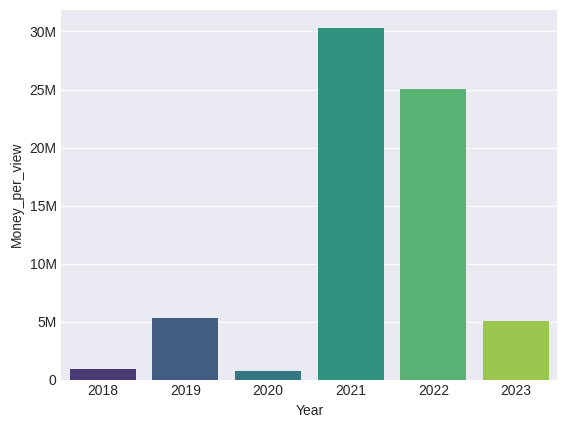

In [78]:
def format_ticks(value, _):
    if value >= 1e9:
        return f'{value / 1e9:.0f}B'
    elif value >= 1e6:
        return f'{value / 1e6:.0f}M'
    elif value >= 1e3:
        return f'{value / 1e3:.0f}K'
    else:
        return f'{value:.0f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

sns.barplot(x='Year', y='Money_per_view', data=money_per_year, palette='viridis');

In [79]:
def show_data_per_year(year):
    video_data_year = video_data[video_data['Year'] == year]
    return video_data_year

In [80]:
stats_per_year = show_data_per_year(2023)
stats_per_year

,Title,Published_date,Views,Likes,Comments,Month,Year,Money_per_view
0,Funniest Animals On The Internet!,2023-04-25,27560101,509929,14474,Apr,2023,330721.212
1,Level 1 To Level 100 Trickshots!,2023-03-30,18667365,336386,10771,Mar,2023,224008.380
2,Most Expensive Fails!,2023-03-17,35132701,605017,8685,Mar,2023,421592.412
3,Fastest Onion Ever Eaten!,2023-03-14,23985492,344052,4249,Mar,2023,287825.904
4,Impossible 0.0000001% Odds!,2023-03-09,55543522,690193,8129,Mar,2023,666522.264
5,Unluckiest People In The World!,2023-02-24,44216466,584307,9993,Feb,2023,530597.592
6,Rarest Things On Earth!,2023-02-17,55557154,634502,10017,Feb,2023,666685.848
7,Funniest Fails On The Internet!,2023-02-14,19510898,345116,3932,Feb,2023,234130.776
8,1 Tank vs 10 Cars!,2023-02-07,39520273,555985,5362,Feb,2023,474243.276
9,Extremely Satisfying Workers!,2023-01-26,28059634,408501,6725,Jan,2023,336715.608


In [81]:
videos_per_month = stats_per_year.groupby('Month').size().reset_index(name = 'number_of_videos')
videos_per_month

,Month,number_of_videos
0,Apr,1
1,Feb,4
2,Jan,3
3,Mar,4


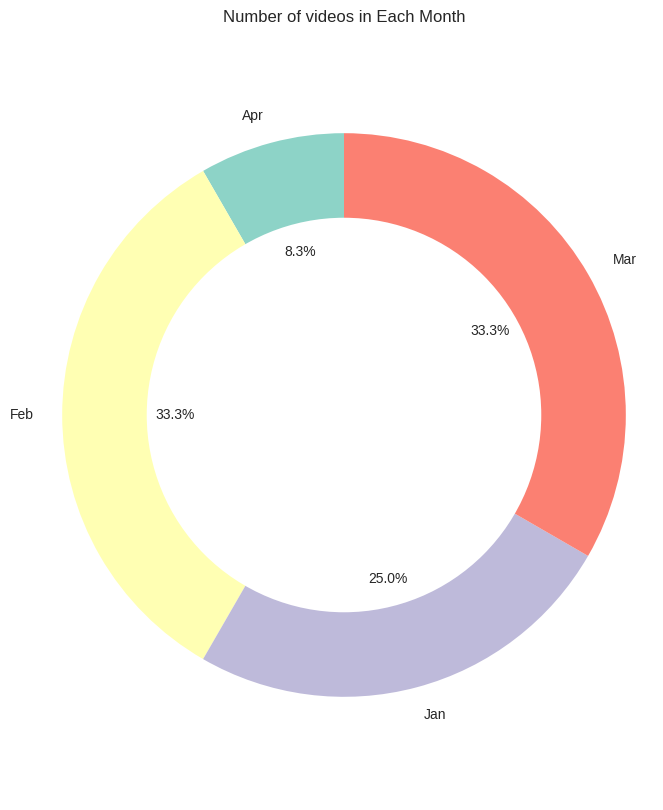

In [82]:
# Plotting a pie chart
plt.figure(figsize=(8, 10))
plt.pie(videos_per_month['number_of_videos'], labels=videos_per_month['Month'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)

center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

plt.axis('equal') 

plt.title('Number of videos in Each Month')
plt.show()

In [83]:
stats_per_year.head()

,Title,Published_date,Views,Likes,Comments,Month,Year,Money_per_view
0,Funniest Animals On The Internet!,2023-04-25,27560101,509929,14474,Apr,2023,330721.212
1,Level 1 To Level 100 Trickshots!,2023-03-30,18667365,336386,10771,Mar,2023,224008.380
2,Most Expensive Fails!,2023-03-17,35132701,605017,8685,Mar,2023,421592.412
3,Fastest Onion Ever Eaten!,2023-03-14,23985492,344052,4249,Mar,2023,287825.904
4,Impossible 0.0000001% Odds!,2023-03-09,55543522,690193,8129,Mar,2023,666522.264


/home/tomo/Desktop/youtube_analisis/env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomo/Desktop/youtube_analisis/env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomo/Desktop/youtube_analisis/env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


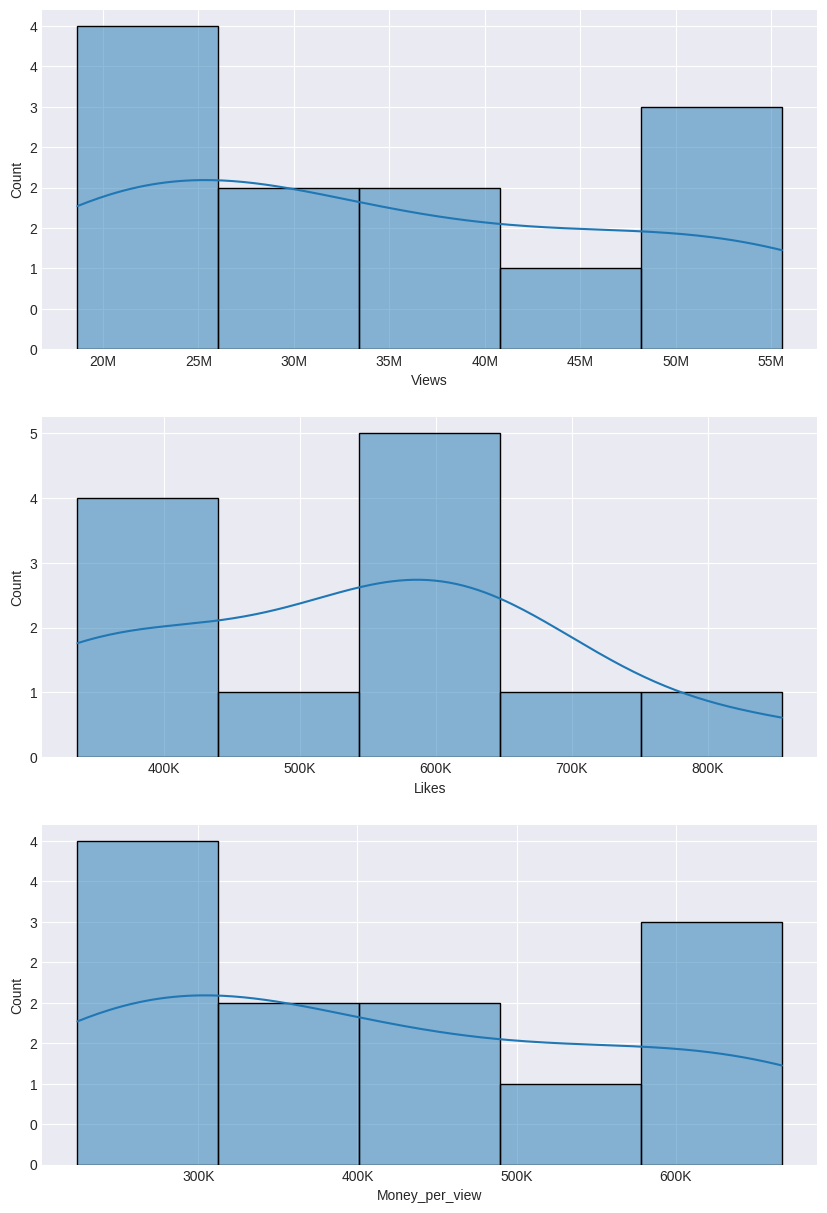

In [84]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Function to format axis labels in a human-readable way
def human_readable_formatter(x, pos):
    for unit in ['', 'K', 'M', 'B', 'T']:
        if abs(x) < 1000.0:
            return f'{x:.0f}{unit}'
        x /= 1000.0

# Apply the formatter to both axes
formatter = FuncFormatter(human_readable_formatter)
for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

sns.histplot(stats_per_year['Views'], kde=True,  ax=ax1)
sns.histplot(stats_per_year['Likes'], kde=True,  ax=ax2)
sns.histplot(stats_per_year['Money_per_view'], kde=True,  ax=ax3)
plt.show()

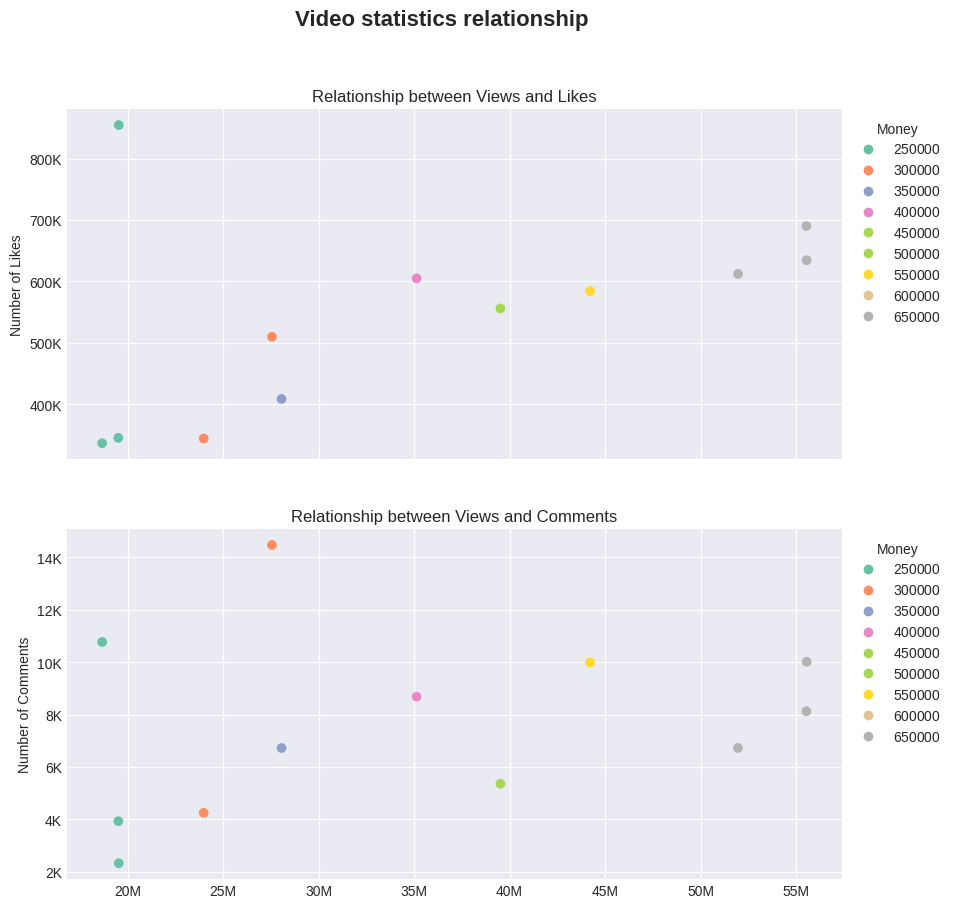

In [85]:
fig, (ax0, ax1) = plt.subplots(nrows=2,
                              ncols=1,
                              figsize=(10,10),
                              sharex=True)

# Function to format axis labels in a human-readable way
def human_readable_formatter(x, pos):
    for unit in ['', 'K', 'M', 'B', 'T']:
        if abs(x) < 1000.0:
            return f'{x:.0f}{unit}'
        x /= 1000.0

# Apply the formatter to both axes
formatter = FuncFormatter(human_readable_formatter)
for ax in [ax0, ax1]:
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

# data for ax0
scatter = ax0.scatter(x = stats_per_year['Views'],
                      y =stats_per_year['Likes'], 
                      c = stats_per_year['Money_per_view'], 
                      cmap = 'Set2' )

ax0.set(title="Relationship between Views and Likes",
        ylabel="Number of Likes");

ax0.legend(*scatter.legend_elements(), title="Money",loc='upper left', bbox_to_anchor=(1, 1));

# data for ax1
scatter = ax1.scatter(x = stats_per_year['Views'],
                      y =stats_per_year['Comments'], 
                      c = stats_per_year['Money_per_view'], 
                      cmap = 'Set2' )

ax1.set(title="Relationship between Views and Comments",
        ylabel="Number of Comments");

ax1.legend(*scatter.legend_elements(), title="Money", loc='upper left', bbox_to_anchor=(1, 1));

fig.suptitle("Video statistics relationship", fontsize=16, fontweight="bold");

## Prediction for future using Prophet lib

In [86]:
ds = video_data['Published_date']
y = video_data['Money_per_view']

data_for_pred = pd.DataFrame({'ds': ds, 'y': y})
data_for_pred.head()

,ds,y
0,2023-04-25,330721.212
1,2023-03-30,224008.380
2,2023-03-17,421592.412
3,2023-03-14,287825.904
4,2023-03-09,666522.264


In [87]:
m = Prophet()
m.fit(data_for_pred)

10:49:40 - cmdstanpy - INFO - Chain [1] start processing
10:49:40 - cmdstanpy - INFO - Chain [1] done processing


In [88]:
future = m.make_future_dataframe(periods=365)
future.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      605 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 4.9 KB


In [89]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
600,2024-04-20,426184.267062,239610.604810,623099.548369
601,2024-04-21,461745.897302,258422.877482,643444.571315
602,2024-04-22,517878.629889,313628.764361,717527.504373
603,2024-04-23,449479.539702,238790.134203,650196.144012
604,2024-04-24,482929.595984,301810.821287,683583.458297


/home/tomo/Desktop/youtube_analisis/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/tomo/Desktop/youtube_analisis/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


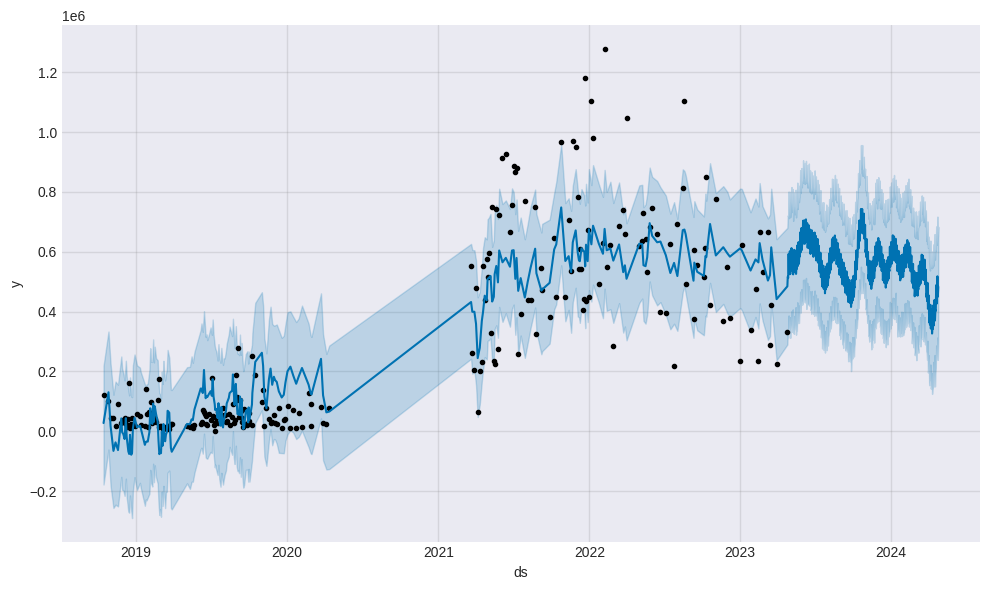

In [90]:
fig1 = m.plot(forecast)

/home/tomo/Desktop/youtube_analisis/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/tomo/Desktop/youtube_analisis/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/tomo/Desktop/youtube_analisis/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing pytho

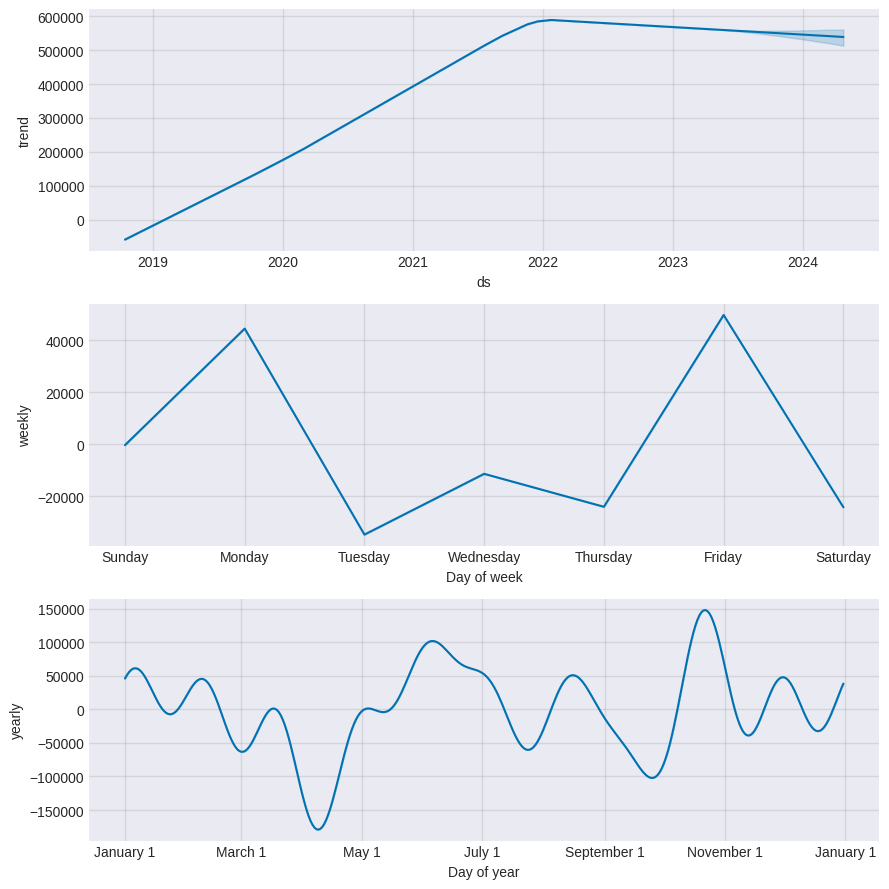

In [91]:
fig2 = m.plot_components(forecast)